<a href="https://colab.research.google.com/github/brahimje/DataMining/blob/main/ImageMining/Atelier2_Classification_BrahimJELLITE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><bold>Image mining
Atelier N 2 : Classification</bold>

Prof : My Abdelouahed Sabri
abdelouahed.sabri@gmail.com</center></h1>

Table des matières
<ul>
1	Introduction </br>
2 Implémentation </br>
2.1 Préparation de la base d’images </br>

> 2.2 Objectif </br>
2.3 Extraction de caractéristiques (features extraction) </br>
2.4 Apprentissage </br>
2.1 Prédiction de la classe d’une nouvelle image </br>
2.2 Evaluation du modèle de classification </br>
2.3 Etude comparative avec d’autres algorithmes de classification </br>

3 Conclusion </br>
4 Todo </br>



---

**TO DO** </br>
> Jusqu’ici, les résultats de classification par les algorithmes SVM, KNN et Arbre de Décision sont
réalisé avec des paramètres basiques alors qu’il y a d’autres paramètres et d’autres algorithmes de
classification à modifier et à utiliser pour améliorer le taux de classification.
Votre tâche dans cette partie est de :

1-Faire d’autres tests pour accroitre le taux de classification en utilisant la notion de training/test comme dans les exemples présentés précédemment afin d’identifier le meilleur algorithme de classification avec les bons paramètres.

2-Prédire les étiquettes des images dans le dossier « DataToPredict ». À noter que dans cette partie le training doit être réalisé sur la base entière. Les étiquettes prédites ainsi que les noms des images doivent être enregistrés dans un fichier « Prediction_corelDB_VotreNom_Master.csv ». Le fichier est à envoyer à l’adresse email « abdelouahed.sabri@usmba.ac.ma » au plus-tard le dimanche prochain.

a. Le contenu du fichier *.csv doit être comme suit :
Name,classe </br>
29011.jpg,obj_car </br>
29013.jpg,obj_car </br>
29055.jpg,obj_car </br>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import os
import scipy.spatial.distance as dist
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
import pickle
import cv2
import skimage.feature as feature
from matplotlib import image
from os import listdir
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree

# Feature Extraction

In [ ]:
def color_Moments(img):
  height = img.shape[0]
  width = img.shape[1]
  listR = []
  listG = []
  listB = []
  somme=0
  for i in range(width):
    for j in range(height):
        
        # getting the RGB pixel value.
        r, g, b = img[j][i]
        listR.append(r)
        listG.append(g)
        listB.append(b)

  list=[]
  list.append(np.mean(listR))
  list.append(np.std(listR))
  list.append(np.mean(listG))
  list.append(np.std(listG))
  list.append(np.mean(listB))
  list.append(np.std(listB))
  colorFeatures=np.array(list)
  
  return colorFeatures

In [ ]:
def hsvHistogramFeatures(image):
  img_HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  hist = cv2.calcHist([img_HSV], [0, 1, 2], None, [8, 2, 2],[0, 180, 0, 256, 0, 256])
  hist = cv2.normalize(hist, hist).flatten()
  return hist

In [ ]:
def form(image):
  img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  contours,v = cv2.findContours(img, 1, 2)
  cnt = contours[0]
  m = cv2.moments(cnt)
  huMoments = cv2.HuMoments(m)
  huMoments = np.ravel(huMoments)
  return huMoments

In [ ]:
def texture (image) :
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  graycom = feature.greycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)
  contrast = feature.greycoprops(graycom, 'contrast')
  homogeneity = feature.greycoprops(graycom, 'homogeneity')
  energy = feature.greycoprops(graycom, 'energy')
  correlation = feature.greycoprops(graycom, 'correlation')

  list=[]
  list.append(np.mean(contrast/np.sum(contrast)))
  list.append(np.mean(homogeneity/np.sum(homogeneity)))
  list.append(np.mean(energy/np.sum(energy)))
  list.append(np.mean(correlation/np.sum(correlation)))

  list = np.ravel(list)
  return list

In [ ]:
def getFeatures(image):
  cl_moments = color_Moments(image)
  hist = hsvHistogramFeatures(image)
  frm=form(image)
  txt=texture(image)
  vect_descripteur=[]
  
  for i in range(len(cl_moments)):
    vect_descripteur.insert(i,cl_moments[i])
  
  for i in range(len(hist)):
    vect_descripteur.insert(i+len(cl_moments),hist[i])
  
  for i in range(len(frm)):
    vect_descripteur.insert(i+len(cl_moments)+len(hist),frm[i])
  
  for i in range(len(txt)):
    vect_descripteur.insert(i+len(cl_moments)+len(frm)+len(hist),txt[i])
  
  vect_descripteur = vect_descripteur/np.mean(vect_descripteur)
  
  return vect_descripteur

In [ ]:
Categories=['obj_car','obj_ship']

flat_data_arr=[]
target_arr=[]
DataToPredict=[]

datadir='/content/drive/MyDrive/dataset/DB2C'

for i in Categories:
  print(f'loading... => {i}')
  path= datadir +'/'+i
  for filename in listdir(path):
    img_array=image.imread(path+'/' + filename)
    flat_data_arr.append(getFeatures(img_array))
    target_arr.append(Categories.index(i))
  print(f'{i} loaded successfully')

for filename in listdir('/content/drive/MyDrive/dataset/DataToPredict/'):
    img_array=image.imread('/content/drive/MyDrive/dataset/DataToPredict/' + filename)
    DataToPredict.append(getFeatures(img_array))

flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data)
df['Target']=target 

loading... => obj_car
obj_car loaded successfully
loading... => obj_ship
obj_ship loaded successfully


In [ ]:
x=df.iloc[:,:-1]
y=df.iloc[:,-1]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=77,stratify=y)
print(x_train.shape, y_train.shape)

(490, 49) (490,)


# ***SVM algorithm:***
---




In [ ]:
param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
svc=svm.SVC(probability=True)
model=GridSearchCV(svc,param_grid)
model.fit(x_train,y_train)
model2=GridSearchCV(svc,param_grid)
model2.fit(x,y)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['rbf', 'poly']})

In [ ]:
y_pred=model.predict(x_test)
print(f"The model accuracy {accuracy_score(y_pred,y_test)}")
pickle.dump(model,open('img_model.p','wb'))
pickle.dump(model2,open('img_model2.p','wb'))
print("Pickle is dumped successfully")
model=pickle.load(open('img_model.p','rb'))

The model accuracy 0.9693877551020408
Pickle is dumped successfully


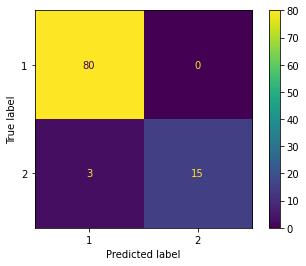

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
classNames = np.arange(1,6)
# Convert to discrete values for confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classNames)
disp.plot()

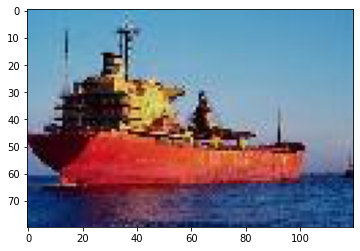

obj_car = 27.66427282928291%
obj_ship = 72.3357271707171%
The predicted image is : obj_ship


In [ ]:
img_requete=image.imread('/content/drive/MyDrive/dataset/ImageRequete.jpg')
plt.imshow(img_requete)
plt.show()
l=[getFeatures(img_requete)]
probability=model.predict_proba(l)
for ind,val in enumerate(Categories):
  print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[model.predict(l)[0]])
model2=pickle.load(open('img_model2.p','rb'))
fichier = open("/content/drive/MyDrive/dataset/Prediction_corelDB_SVM_JELLITE_Brahim_MSID.csv", "w")
for filename in listdir('/content/drive/MyDrive/dataset/DataToPredict'):
  img_requete=image.imread('/content/drive/MyDrive/dataset/DataToPredict/' + filename)
  l=[getFeatures(img_requete)]
  probability=model2.predict_proba(l)
  fichier.write(filename+','+Categories[model2.predict(l)[0]]+'\n')
fichier.close()


# ***KNN algorithm:***
---

In [ ]:
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn2 = KNeighborsClassifier(n_neighbors = 3)
# Fit the classifier to the data
knn.fit(x_train,y_train)
knn2.fit(x,y)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred_knn=model.predict(x_test)
print(f"The model accuracy {accuracy_score(y_pred_knn,y_test)}")
pickle.dump(knn,open('img_knn.p','wb'))
pickle.dump(knn2,open('img_knn2.p','wb'))
print("Pickle is dumped successfully")
model_knn=pickle.load(open('img_knn.p','rb'))

The model accuracy 0.9693877551020408
Pickle is dumped successfully


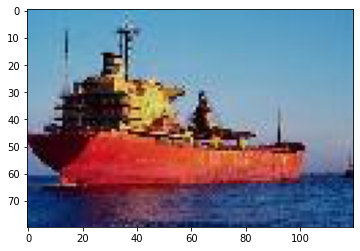

obj_car = 33.33333333333333%
obj_ship = 66.66666666666666%
The predicted image is : obj_ship


In [ ]:
img_requete=image.imread('/content/drive/MyDrive/dataset/ImageRequete.jpg')
plt.imshow(img_requete)
plt.show()
l=[getFeatures(img_requete)]
probability=knn.predict_proba(l)
for ind,val in enumerate(Categories):
  print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[model_knn.predict(l)[0]])

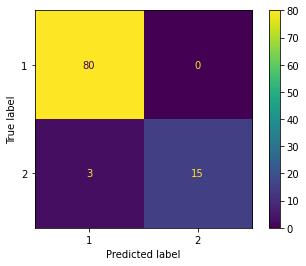

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
classNames = np.arange(1,6)
# Convert to discrete values for confusion matrix
cm2 = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=classNames)
disp.plot()

In [ ]:
model_knn2=pickle.load(open('img_knn2.p','rb'))
fichier = open("/content/drive/MyDrive/dataset/Prediction_corelDB_KNN_JELLITE_Brahim_MSID.csv", "w")
for filename in listdir('/content/drive/MyDrive/dataset/DataToPredict'):
  img_requete=image.imread('/content/drive/MyDrive/dataset/DataToPredict/' + filename)
  l=[getFeatures(img_requete)]
  probability=knn2.predict_proba(l)
  fichier.write(filename+','+Categories[model_knn2.predict(l)[0]]+'\n')
fichier.close()

# ***L'arbre de décision (decision tree):***
---



In [ ]:
DTC = tree.DecisionTreeClassifier()
DTC2 = tree.DecisionTreeClassifier()
# Fit the classifier to the data
DTC.fit(x_train,y_train)
DTC2.fit(x,y)

DecisionTreeClassifier()

In [ ]:
y_pred_dtc=DTC.predict(x_test)

print(f"The model is {accuracy_score(y_pred_dtc,y_test)} accurate")
pickle.dump(DTC,open('img_dtc.p','wb'))
pickle.dump(DTC2,open('img_dtc2.p','wb'))
print("Pickle is dumped successfully")
model_dtc=pickle.load(open('img_dtc.p','rb'))

The model is 0.9183673469387755 accurate
Pickle is dumped successfully


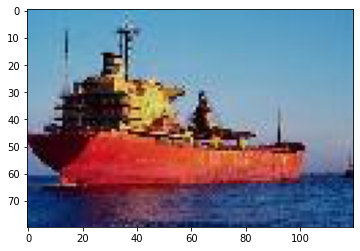

obj_car = 0.0%
obj_ship = 100.0%
The predicted image is : obj_ship


In [ ]:
img_requete=image.imread('/content/drive/MyDrive/dataset/ImageRequete.jpg')
plt.imshow(img_requete)
plt.show()
l=[getFeatures(img_requete)]
probability=DTC.predict_proba(l)
for ind,val in enumerate(Categories):
  print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[model_dtc.predict(l)[0]])

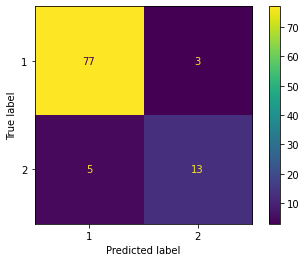

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
classNames = np.arange(1,6)
# Convert to discrete values for confusion matrix
cm2 = confusion_matrix(y_test, y_pred_dtc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=classNames)
disp.plot()

In [ ]:
model_dtc2=pickle.load(open('img_dtc2.p','rb'))
fichier = open("/content/drive/MyDrive/dataset/Prediction_corelDB_DTC_JELLITE_Brahim_MSID.csv", "w")
for filename in listdir('/content/drive/MyDrive/dataset/DataToPredict'):
  img_requete=image.imread('/content/drive/MyDrive/dataset/DataToPredict/' + filename)
  l=[getFeatures(img_requete)]
  probability=DTC2.predict_proba(l)
  fichier.write(filename+','+Categories[model_dtc2.predict(l)[0]]+'\n')
fichier.close()

**Ici le lien des fichier csv:**
https://drive.google.com/drive/folders/17zzgwC-n0J2GL7mHO5ugVVgZTb7VlsS-?usp=sharing